In [28]:
#import packages
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
import nltk
import re
from nltk.corpus import stopwords


import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import numpy as np 

from sklearn.decomposition import LatentDirichletAllocation as LDA
      
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# do not print warnings
import warnings
warnings.filterwarnings("ignore")

In [13]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 1.0 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 24.0 MB 7.2 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 8.5 MB/s eta 0:00:01
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136882 sha256=4b6a36c20978d9674b1123347dd38a60d7349adb741b6423839a555622bdc9f4
  Stored in directory: /Users/thuynguyenphan/Library/Caches/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
Successfully built pyLDAvis


In [15]:
#load data
df = pd.read_csv("job_offers_original_2.csv")

In [16]:
#drop all columns and keeps only job_title and job_description
df = df[['job_title', 'job_description']]

In [4]:
df.head()

,job_title,job_description
0,Data Engineer,Do you want to work on the most pressing probl...
1,Data Engineer,"We strongly encourage people of colour, lesbia..."
2,Data Engineer,"We strongly encourage people of colour, lesbia..."
3,Data Engineer,"DescriptionAt The Data Shed, we've been workin..."
4,Data Engineer,Are you a Data Engineer interested in or curre...


In [17]:
#(?<![A-Z\W])  what precedes is a word character EXCEPT for capital letters
#(?=[A-Z])     and what follows is a capital letter
def sepa(text): 
    text = re.sub(r'(?<![A-Z\W])(?=[A-Z])', ' ', text)
    return(text)

df['job_description']=df['job_description'].apply(sepa)

In [19]:
df["job_description"] = df["job_description"].str.lower() #lowercase
df['job_description'] = df['job_description'].str.replace('\d+', '') # remove digits
df['job_description'] = df['job_description'].str.replace('[^\w\s]', ' ') # remove punctuation 

In [20]:
%%time
# import stop words
stop_words=nltk.corpus.stopwords.words('english')
# add more words to remove
remove_key_w = ['show','le','please','feel','free','work','working','role','opportunity','data','role'
               ,'skill','experience','company','experienced','paid'',''bonus','applicant','candidate']

def clean_text(text):
    le=WordNetLemmatizer()
    word_tokens=word_tokenize(text)
    tokens=[le.lemmatize(w) for w in word_tokens if w not in stop_words and len(w)>3]
    cleaned_text= [t for t in tokens if t not in remove_key_w]
    return cleaned_text

df['desc_tokenized']=df['job_description'].apply(clean_text)


CPU times: user 5.64 s, sys: 43.8 ms, total: 5.69 s
Wall time: 5.73 s


In [11]:
pd.set_option("display.max_colwidth", -1)

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [106]:
df['desc_tokenized'][1]

['strongly',
 'encourage',
 'people',
 'colour',
 'lesbian',
 'bisexual',
 'transgender',
 'queer',
 'binary',
 'people',
 'veteran',
 'parent',
 'individual',
 'disability',
 'apply',
 'bumble',
 'equal',
 'employer',
 'welcome',
 'everyone',
 'team',
 'need',
 'reasonable',
 'adjustment',
 'point',
 'application',
 'interview',
 'process',
 'know',
 'application',
 'note',
 'pronoun',
 'example',
 'strongly',
 'encourage',
 'people',
 'colour',
 'lesbian',
 'bisexual',
 'transgender',
 'queer',
 'binary',
 'people',
 'veteran',
 'parent',
 'individual',
 'disability',
 'apply',
 'bumble',
 'equal',
 'employer',
 'welcome',
 'everyone',
 'team',
 'need',
 'reasonable',
 'adjustment',
 'point',
 'application',
 'interview',
 'process',
 'know',
 'application',
 'note',
 'pronoun',
 'example',
 'bumble',
 'looking',
 'engineer',
 'participate',
 'development',
 'collecting',
 'framework',
 'service',
 'tool',
 'cross',
 'functional',
 'department',
 'based',
 'london',
 'reporting',
 'e

In [8]:
# we have already tokenize the text so we need a dummy one to bypass tokenization
def dummy_tokenizer(string): return string

vect =TfidfVectorizer(tokenizer=dummy_tokenizer, lowercase=False)
vect_text=vect.fit_transform(df['desc_tokenized'])

In [9]:
# create dictionary
dictionary = corpora.Dictionary(df['desc_tokenized'])

# create document term matrix
bow = [dictionary.doc2bow(text) for text in df['desc_tokenized']]

In [10]:
%%time
# Determining the number of topics
best_num = float('NaN')
best_score = 0
coherence_values = []
# compute the coherence scores for each number of topics
for i in range(2,20):
    
    # create lda model with i topics
    lda = LdaModel(corpus=bow, num_topics=i, id2word=dictionary, random_state=42)
    
    # obtain the coherence score
    coherence_model = CoherenceModel(model=lda, texts=df['desc_tokenized'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_values.append(coherence_model.get_coherence())
    if coherence_score > best_score:
        best_num = i
        best_score = coherence_score

print(f'The coherence score is highest ({best_score}) with {best_num} topics.')

The coherence score is highest (0.32219922842071974) with 2 topics.
CPU times: user 58.8 s, sys: 2.69 s, total: 1min 1s
Wall time: 3min 1s


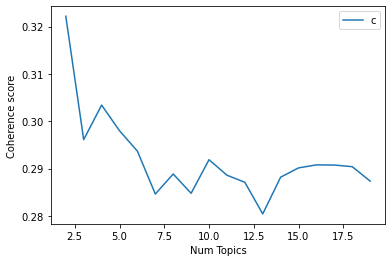

In [90]:
# Show graph
x = range(2,20)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [91]:
# build the lda model
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow,
                                          id2word=dictionary,
                                        num_topics=2, 
                                        random_state=42)

In [92]:
# show the words most strongly associated with each topic
for topic in lda_model.print_topics():
    print(topic)

(0, '0.014*"team" + 0.011*"business" + 0.007*"solution" + 0.006*"technology" + 0.005*"client" + 0.005*"customer" + 0.005*"ability" + 0.005*"database" + 0.005*"development" + 0.005*"model"')
(1, '0.014*"business" + 0.012*"team" + 0.006*"solution" + 0.005*"database" + 0.005*"support" + 0.005*"analytics" + 0.005*"looking" + 0.005*"technology" + 0.005*"process" + 0.004*"knowledge"')


In [16]:
df_tf_idf = pd.DataFrame(
    data=vect_text.todense().round(2),
    columns=vect.get_feature_names_out()
)

In [23]:
number_topics = 2
lda_model=LDA(n_components=2,
learning_method='online',random_state=42,n_jobs=-1,doc_topic_prior = 0.95,topic_word_prior = 0.01) 
lda_top=lda_model.fit_transform(vect_text)

In [93]:
number_topics = 2
lda_model=LDA(n_components=number_topics,
learning_method='online',random_state=42,n_jobs=-1,doc_topic_prior = 0.9,topic_word_prior = 0.01) 
lda_top=lda_model.fit_transform(vect_text)

In [94]:
print("Document 0: ")
for i,topic in enumerate(lda_top[0]):
    print("Topic ",i,": ",topic*100,"%")

Document 0: 
Topic  0 :  53.09149823363083 %
Topic  1 :  46.90850176636916 %


In [95]:
vocab = vect.get_feature_names()
for i, comp in enumerate(lda_model.components_):
    vocab_comp = zip(vocab, comp)  
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    for t in sorted_words:
        print(t[0],end=" ")
    print("\n")

Topic 0: 
database developer server looking development application team administrator engineer tool 

Topic 1: 
business team solution model customer technology analytics architecture design client 



In [ ]:
# topic 1: more business oriented, customer facing, analysis 
# topic 2: developer, engineer

In [96]:
pyLDAvis.enable_notebook()

In [97]:
%%time

pyLDAvis.sklearn.prepare(lda_model, vect_text, vect)

CPU times: user 67 ms, sys: 30.5 ms, total: 97.5 ms
Wall time: 696 ms


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.223981  0.0       1        1  81.487096
0     -0.223981  0.0       2        1  18.512904, topic_info=             Term        Freq       Total Category  logprob  loglift
1687     database  101.000000  101.000000  Default  30.0000  30.0000
1884    developer   52.000000   52.000000  Default  29.0000  29.0000
5952       server   44.000000   44.000000  Default  28.0000  28.0000
1886  development   51.000000   51.000000  Default  27.0000  27.0000
3923      looking   50.000000   50.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1151       client   14.868534   55.381362   Topic2  -5.5094   0.3717
391      approach   12.663257   20.478242   Topic2  -5.6699   1.2060
4894     platform   13.275132   41.005451   Topic2  -5.6227   0.5589
5116      product   13.235826   42.583571   Topic2  -5.6257   0.5182
2933         good   12.465598   34.750235   Topic2  -5.6857   0.6615

[195 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2         1  0.888570        ability
2         2  0.093534        ability
23        2  0.932886     accelerate
82        1  0.997165         across
141       1  0.140834  administrator
...     ...       ...            ...
7169      2  0.853554         vision
7317      2  1.050036         window
7329      1  0.795720         within
7329      2  0.198930         within
7384      1  0.980839           year

[214 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [36]:
def new_tokenized(text):
    remove= ['plus','bank','holiday','annual', 'leave','join','today','release','equal','employer','united','kingdom','salary'
            ,'application','interview']
    corpus=[t for t in text if t not in remove]
    return corpus
df['desc_tokenized']=df['desc_tokenized'].apply(new_tokenized)

<AxesSubplot:xlabel='Tri-gram Frequency', ylabel='Top 20 tri-grams mentioned in Job descriptions'>

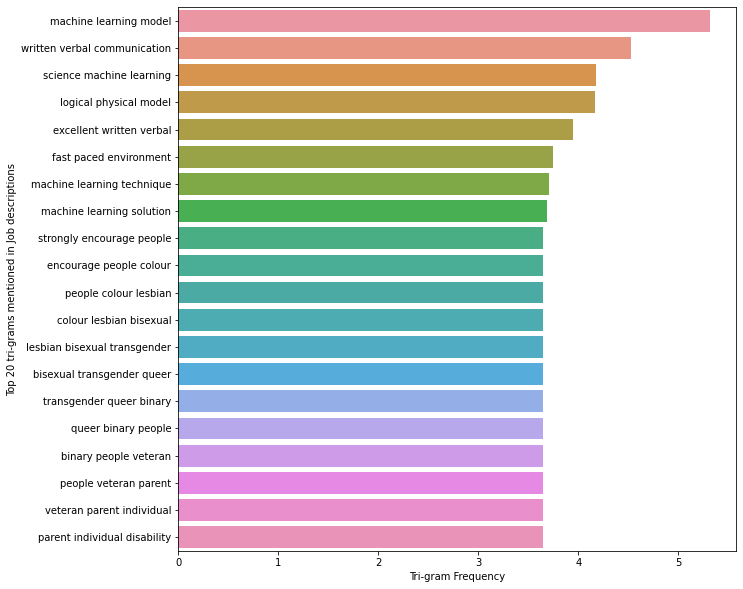

In [37]:
def _get_top_ngram(corpus, n):
        vec = TfidfVectorizer(tokenizer=dummy_tokenizer,ngram_range=(n, n), lowercase=False).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]
top_n_bigrams=_get_top_ngram(df['desc_tokenized'],3)[:20]
x,y=map(list,zip(*top_n_bigrams))
plt.figure(figsize=(10,10))
plt.xlabel("Tri-gram Frequency")
plt.ylabel("Top 20 tri-grams mentioned in Job descriptions")
sns.barplot(x=y,y=x)

<AxesSubplot:xlabel='Bi-gram Frequency', ylabel='Top 20 Bi-grams mentioned in Job descriptions'>

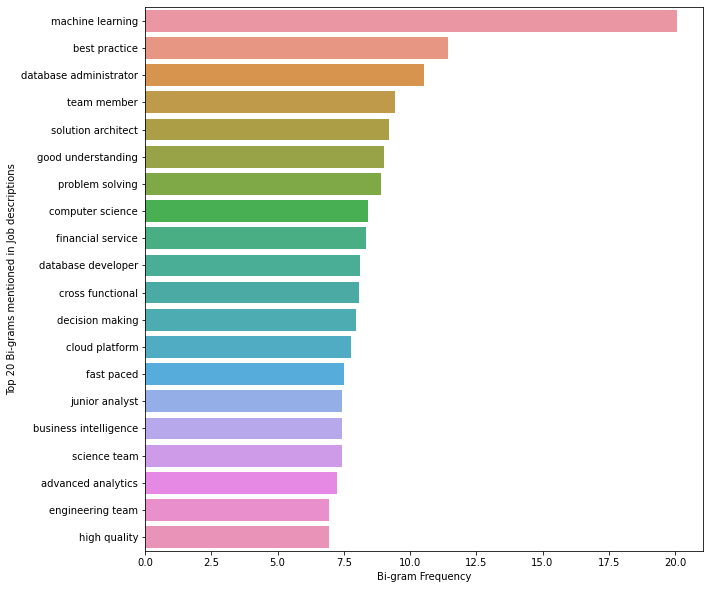

In [41]:
top_n_bigrams=_get_top_ngram(df['desc_tokenized'],2)[:20]
x,y=map(list,zip(*top_n_bigrams))
plt.figure(figsize=(10,10))
plt.xlabel("Bi-gram Frequency")
plt.ylabel("Top 20 Bi-grams mentioned in Job descriptions")
sns.barplot(x=y,y=x)

<AxesSubplot:xlabel='Unigram Frequency', ylabel='Top 20 Unigrams mentioned in Job descriptions'>

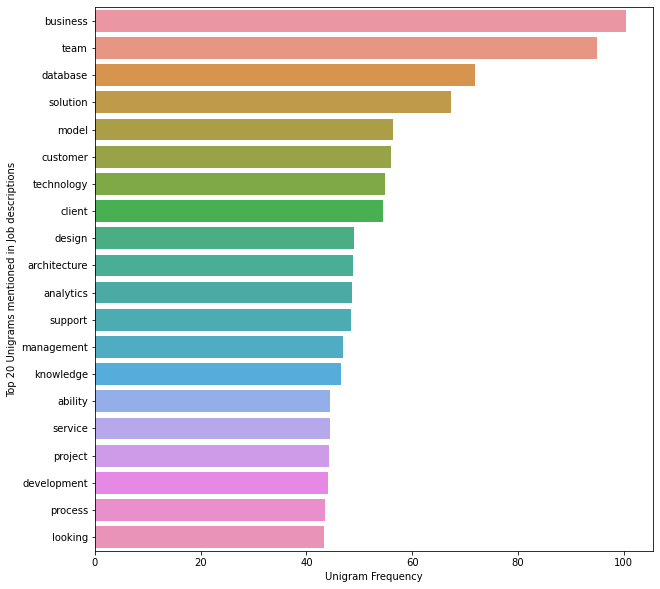

In [42]:
top_n_bigrams=_get_top_ngram(df['desc_tokenized'],1)[:20]
x,y=map(list,zip(*top_n_bigrams))
plt.figure(figsize=(10,10))
plt.xlabel("Unigram Frequency")
plt.ylabel("Top 20 Unigrams mentioned in Job descriptions")
sns.barplot(x=y,y=x)